In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load your dataset
# df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\New folder\dataset\final_merged_output.csv")


In [47]:
df=pd.read_csv("final_merged_output1.csv")

In [48]:

# Parse dates
df['LeaveStartDate'] = pd.to_datetime(df['LeaveStartDate'], errors='coerce')
df['LeaveEndDate'] = pd.to_datetime(df['LeaveEndDate'], errors='coerce')

In [49]:
# Drop invalid rows
df = df.dropna(subset=['LeaveStartDate', 'LeaveEndDate'])

# Ensure End >= Start
df = df[df['LeaveEndDate'] >= df['LeaveStartDate']]


In [50]:

# Expand leave dates: create daily leave records
leave_days = []
for _, row in df.iterrows():
    days = pd.date_range(start=row['LeaveStartDate'], end=row['LeaveEndDate'])
    leave_days.extend(days)


In [51]:

# Convert to DataFrame
leave_df = pd.DataFrame(leave_days, columns=['Date'])
leave_df['Leave'] = 1


In [52]:

# Convert to DataFrame
leave_df = pd.DataFrame(leave_days, columns=['Date'])
leave_df['Leave'] = 1

In [53]:


# Group by date
daily_leave = leave_df.groupby('Date').sum().asfreq('D').fillna(0)

# Add weekday
daily_leave['Weekday'] = daily_leave.index.day_name()

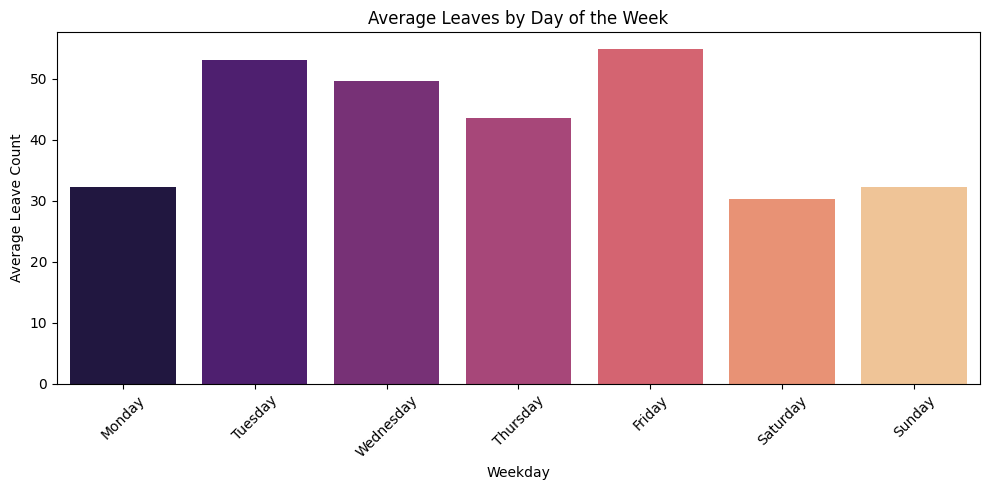

In [54]:
# Step 1: Plot average leaves per weekday
weekday_avg = daily_leave.groupby('Weekday')['Leave'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette="magma")
plt.title('Average Leaves by Day of the Week')
plt.ylabel('Average Leave Count')
plt.xlabel('Weekday')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [55]:

# Step 2: Time series forecasting using SARIMA
train = daily_leave['Leave'][:-14]
test = daily_leave['Leave'][-14:]

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit()

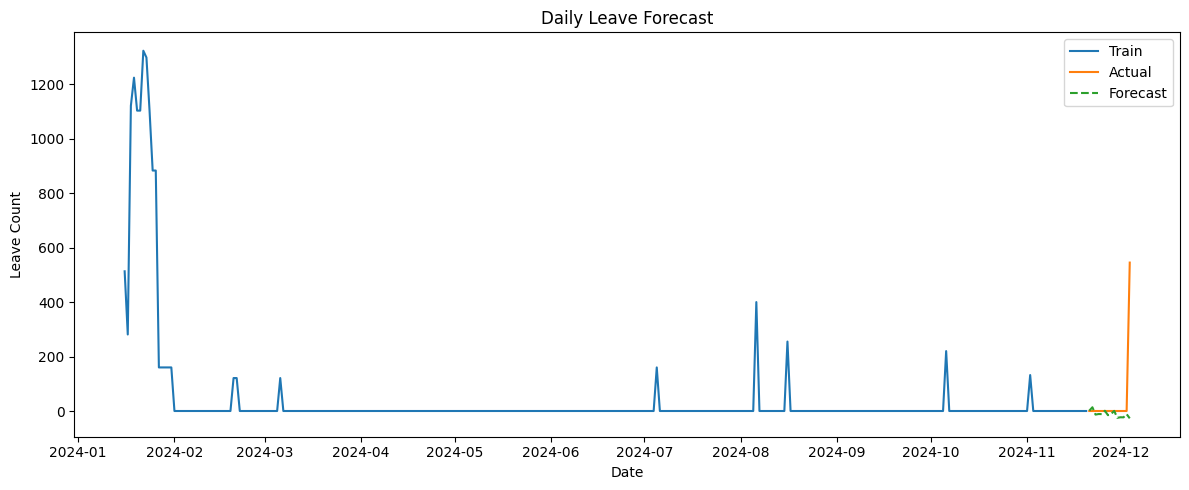

In [56]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('Daily Leave Forecast')
plt.xlabel('Date')
plt.ylabel('Leave Count')
plt.legend()
plt.tight_layout()
plt.show()


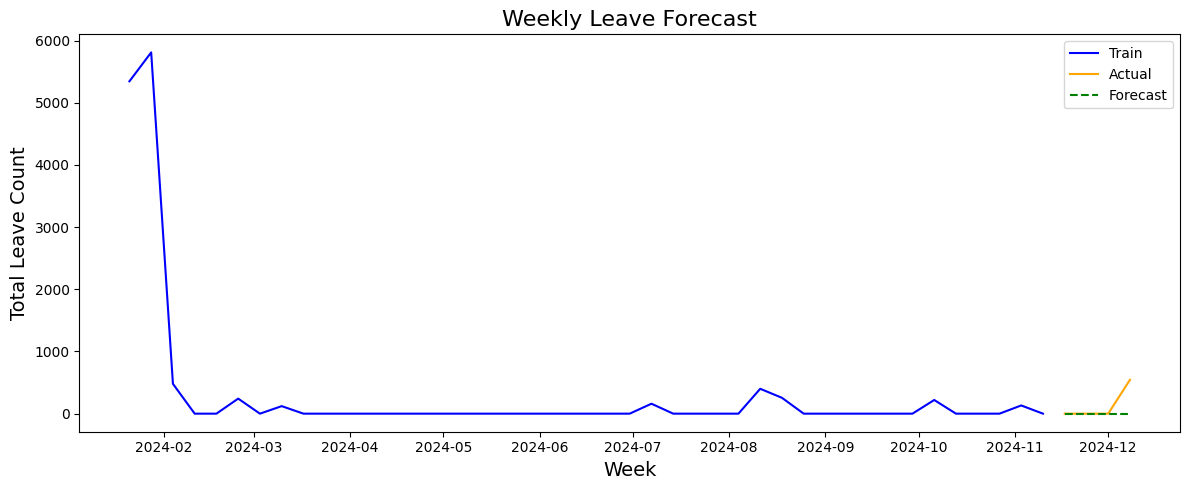

In [58]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming the SARIMA model has already been fitted as in the previous steps
# Plotting the weekly forecast
plt.figure(figsize=(12, 5))

# Train data (weekly)
plt.plot(train_w.index, train_w, label='Train', color='blue')

# Actual data (weekly test period)
plt.plot(test_w.index, test_w, label='Actual', color='orange')

# Forecasted data (for the same weekly period as the test data)
plt.plot(test_w.index, forecast_w, label='Forecast', linestyle='--', color='green')

# Adding labels, title, and legend
plt.title('Weekly Leave Forecast', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Total Leave Count', fontsize=14)
plt.legend(loc='best')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


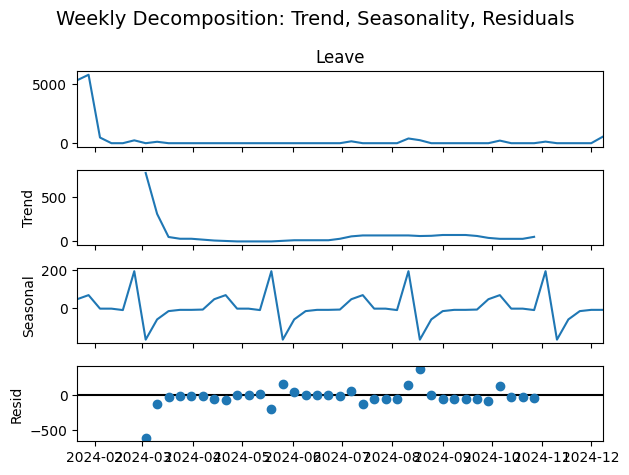

In [43]:
# Adjusting the period to a smaller value, e.g., 12 for monthly seasonality
decomp = seasonal_decompose(weekly_leave, model='additive', period=12)

# Plot decomposition
decomp.plot()
plt.suptitle("Weekly Decomposition: Trend, Seasonality, Residuals", fontsize=14)
plt.tight_layout()
plt.show()


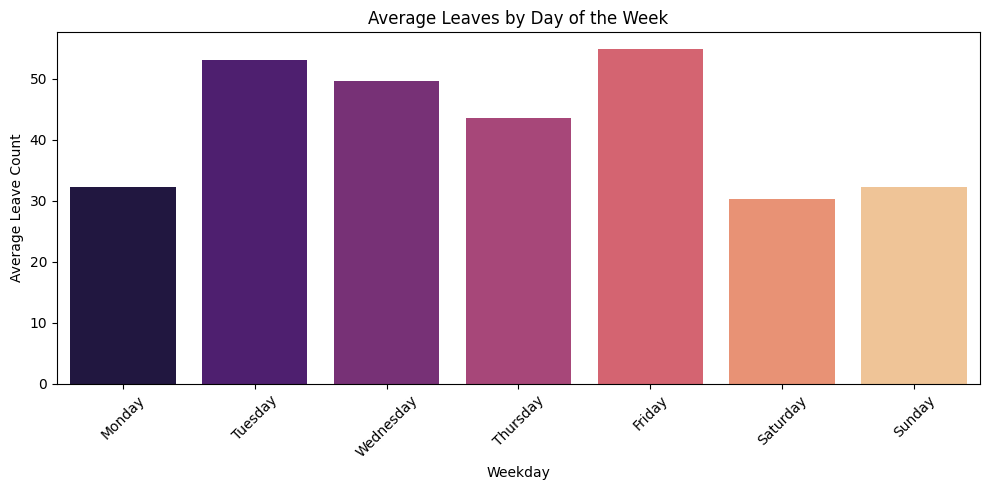

ADF Statistic: -4.274757885837494
p-value: 0.0004911104682923467
The series is likely stationary.
ADF Statistic: -8.745114369978333
p-value: 2.9370194182377676e-14
The series is likely stationary.


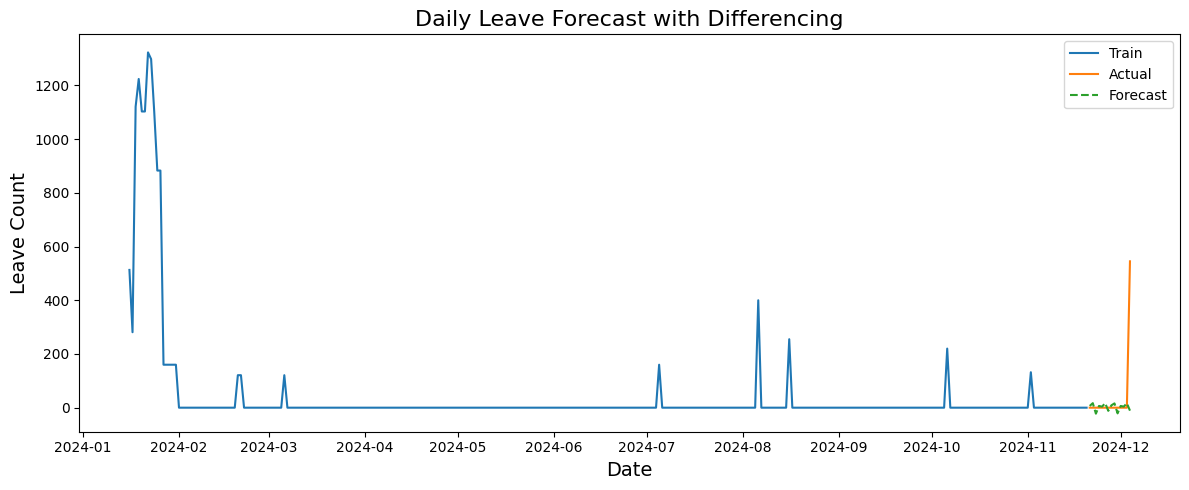

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# Load the file
# df = pd.read_csv('/mnt/data/myProject.ipynb', error_bad_lines=False)

# Parse dates
df['LeaveStartDate'] = pd.to_datetime(df['LeaveStartDate'], errors='coerce')
df['LeaveEndDate'] = pd.to_datetime(df['LeaveEndDate'], errors='coerce')

# Drop invalid rows
df = df.dropna(subset=['LeaveStartDate', 'LeaveEndDate'])

# Ensure End >= Start
df = df[df['LeaveEndDate'] >= df['LeaveStartDate']]

# Expand leave dates: create daily leave records
leave_days = []
for _, row in df.iterrows():
    days = pd.date_range(start=row['LeaveStartDate'], end=row['LeaveEndDate'])
    leave_days.extend(days)

# Convert to DataFrame
leave_df = pd.DataFrame(leave_days, columns=['Date'])
leave_df['Leave'] = 1

# Group by date
daily_leave = leave_df.groupby('Date').sum().asfreq('D').fillna(0)

# Add weekday
daily_leave['Weekday'] = daily_leave.index.day_name()

# Step 1: Plot average leaves per weekday
weekday_avg = daily_leave.groupby('Weekday')['Leave'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette="magma")
plt.title('Average Leaves by Day of the Week')
plt.ylabel('Average Leave Count')
plt.xlabel('Weekday')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 2: Check Stationarity using ADF Test
def check_stationarity(series):
    adf_result = adfuller(series)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    if adf_result[1] > 0.05:
        print("The series is likely non-stationary.")
    else:
        print("The series is likely stationary.")

# Check stationarity for daily_leave (training set)
train = daily_leave['Leave'][:-14]  # Training data (last 14 days as test data)
check_stationarity(train)

# Step 3: If non-stationary, apply differencing
# Difference the data (if necessary)
train_diff = train.diff().dropna()

# Check the differenced data for stationarity
check_stationarity(train_diff)

# Step 4: Fit the SARIMA model after differencing (if needed)
model = SARIMAX(train_diff, order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit()

# Forecast (for the same period as the test data)
forecast = results.predict(start=len(train_diff), end=len(train_diff) + len(daily_leave['Leave'][-14:]) - 1)

# Step 5: Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(daily_leave.index[-14:], daily_leave['Leave'][-14:], label='Actual')  # Actual values for test period
plt.plot(daily_leave.index[-14:], forecast, label='Forecast', linestyle='--')

# Adding labels, title, and legend
plt.title('Daily Leave Forecast with Differencing', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Leave Count', fontsize=14)
plt.legend(loc='best')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


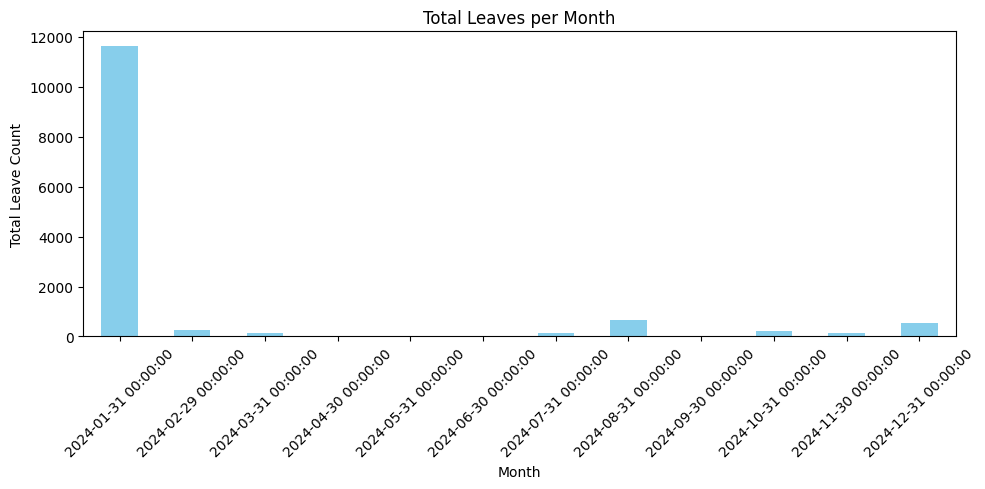

ADF Statistic: -2.08824813581014
p-value: 0.2492662663364989
The series is likely non-stationary.
ADF Statistic: -27.89763548865491
p-value: 0.0
The series is likely stationary.


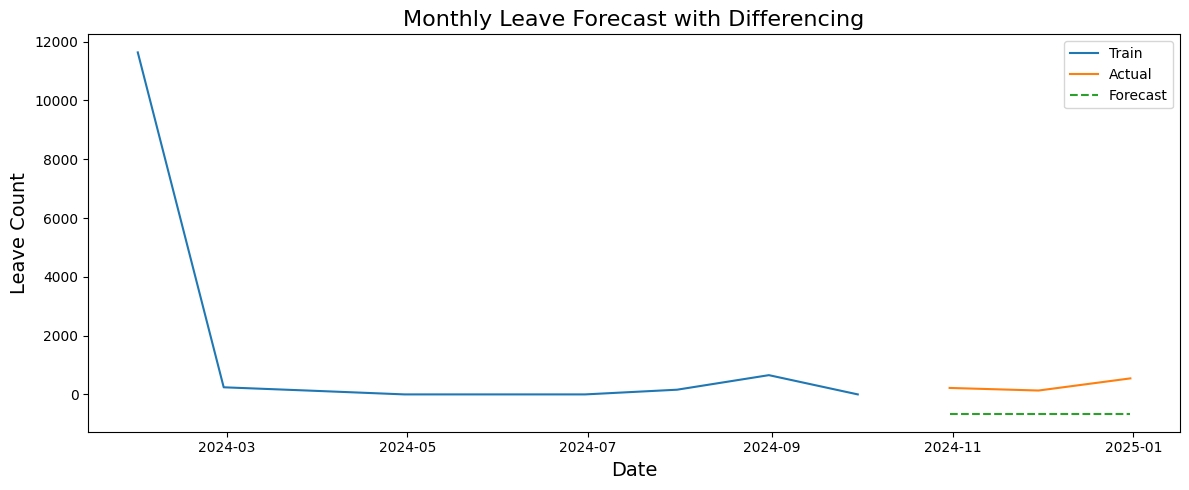

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# Load the file
# df = pd.read_csv('/mnt/data/myProject.ipynb', error_bad_lines=False)

# Parse dates
df['LeaveStartDate'] = pd.to_datetime(df['LeaveStartDate'], errors='coerce')
df['LeaveEndDate'] = pd.to_datetime(df['LeaveEndDate'], errors='coerce')

# Drop invalid rows
df = df.dropna(subset=['LeaveStartDate', 'LeaveEndDate'])

# Ensure End >= Start
df = df[df['LeaveEndDate'] >= df['LeaveStartDate']]

# Expand leave dates: create daily leave records
leave_days = []
for _, row in df.iterrows():
    days = pd.date_range(start=row['LeaveStartDate'], end=row['LeaveEndDate'])
    leave_days.extend(days)

# Convert to DataFrame
leave_df = pd.DataFrame(leave_days, columns=['Date'])
leave_df['Leave'] = 1

# Group by date (daily leave data)
daily_leave = leave_df.groupby('Date').sum().asfreq('D').fillna(0)

# Step 1: Resample the daily leave data to monthly data
monthly_leave = daily_leave.resample('M').sum()

# Add weekday to monthly data (optional for visualization purposes)
monthly_leave['Weekday'] = monthly_leave.index.day_name()

# Step 2: Plot average leaves per month
monthly_avg = monthly_leave['Leave']

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Total Leaves per Month')
plt.ylabel('Total Leave Count')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 3: Check Stationarity using ADF Test
def check_stationarity(series):
    adf_result = adfuller(series)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    if adf_result[1] > 0.05:
        print("The series is likely non-stationary.")
    else:
        print("The series is likely stationary.")

# Check stationarity for monthly_leave (training set)
train = monthly_leave['Leave'][:-3]  # Training data (last 3 months as test data)
check_stationarity(train)

# Step 4: If non-stationary, apply differencing
# Difference the data (if necessary)
train_diff = train.diff().dropna()

# Check the differenced data for stationarity
check_stationarity(train_diff)

# Step 5: Fit the SARIMA model after differencing (if needed)
model = SARIMAX(train_diff, order=(1,1,1), seasonal_order=(1,1,1,12))  # Seasonal order is monthly
results = model.fit()

# Forecast (for the same period as the test data)
forecast = results.predict(start=len(train_diff), end=len(train_diff) + len(monthly_leave['Leave'][-3:]) - 1)

# Step 6: Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(monthly_leave.index[-3:], monthly_leave['Leave'][-3:], label='Actual')  # Actual values for test period
plt.plot(monthly_leave.index[-3:], forecast, label='Forecast', linestyle='--')

# Adding labels, title, and legend
plt.title('Monthly Leave Forecast with Differencing', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Leave Count', fontsize=14)
plt.legend(loc='best')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()
